In [1]:
import pickle as pk
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from helper_utils.utils import *
from evaluation.metrics import *

In [3]:
# Load everything

data_directory = "processed_data"
data_filename_base = "X_top300_201701_201912_30_m_final"
data_filename_ext = ".npz"
data_filename = data_filename_base+data_filename_ext

model_store_directory = "stored_models"
run_info_store_directory = "stored_models"

PLOTS_DIRECTORY = "plots"
DATASET_NAME = "bike-share"
MODEL_NAMES = ["LinearRegressor","FNN"]

run_info = {}

for model_name in MODEL_NAMES:

    run_info_store_filename = "_".join([model_name, "run_info"]) + ".pk"
    run_info_store_filepath = os.path.join(run_info_store_directory, run_info_store_filename)
    run_info[model_name] = (pk.load(open(run_info_store_filepath, "rb")))
    
# history_dict = run_info["history"]
# preds = run_info["predictions"]

data = {}
with np.load(os.path.join(data_directory, data_filename)) as npz_loader:
    for key in npz_loader.files:
        print("{}: {}".format(key, npz_loader[key].shape))
        data[key] = npz_loader[key]

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]

# Input and output dims
input_shape = tuple(list(X_train.shape)[1:])
output_shape = tuple(list(X_train.shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

num_nodes, num_steps, input_features = input_shape
_, _, output_features = output_shape


X_train: (26593, 300, 10, 4)
y_train: (26593, 300, 10, 2)
X_val: (5318, 300, 10, 4)
y_val: (5318, 300, 10, 2)
X_test: (10637, 300, 10, 4)
y_test: (10637, 300, 10, 2)


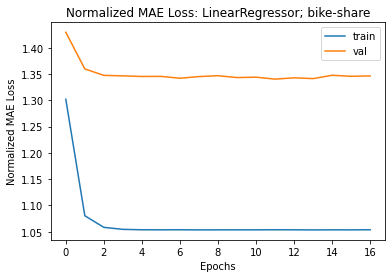

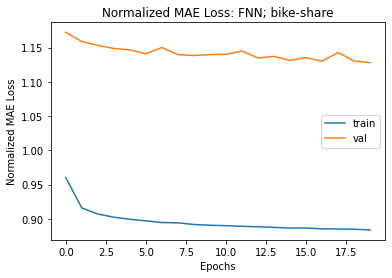

In [4]:
for MODEL_NAME in MODEL_NAMES:
    plt.figure()
    plt.title("Normalized MAE Loss: "+MODEL_NAME+'; '+DATASET_NAME)
    plt.xlabel("Epochs")
    plt.ylabel("Normalized MAE Loss")
    plt.plot(run_info[MODEL_NAME]['history']['loss'],label='train')
    plt.plot(run_info[MODEL_NAME]['history']['val_loss'],label='val')
    plt.legend()
    plt.savefig(os.path.join(PLOTS_DIRECTORY,'loss_'+MODEL_NAME+'_'+DATASET_NAME+'.png'))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

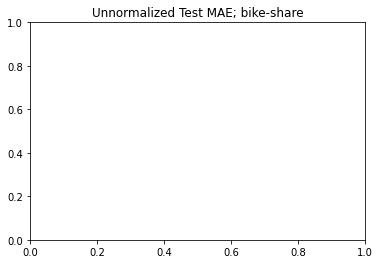

In [5]:
loss_funcs = {'MAE':mae_losses,
              'MAPE':mape_losses,
              'RMSE':rmse_losses}

samples = [0,2,5,8,11]

for loss in loss_funcs:

#     plt.figure(figsize=[8, 2.4])
    plt.figure()
    plt.title("Unnormalized Test "+loss+"; "+DATASET_NAME)
    
    for i,MODEL_NAME in enumerate(MODEL_NAMES):
        losses = loss_funcs[loss](run_info[MODEL_NAME]['predictions'],run_info[MODEL_NAME]['ground_truth'])
        plt.bar((np.arange(1,13)*5+1.4*(i-len(MODEL_NAMES)//2))[samples],losses[samples],width=1.4,label=MODEL_NAME)

    plt.xlabel("Horizon (min)")
    plt.ylabel("Loss")
    plt.legend(loc='lower right',prop={'size': 9})
    plt.savefig(os.path.join(PLOTS_DIRECTORY,loss+'_comparison_'+DATASET_NAME+'.png'))

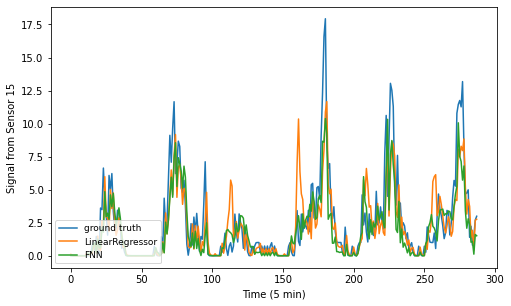

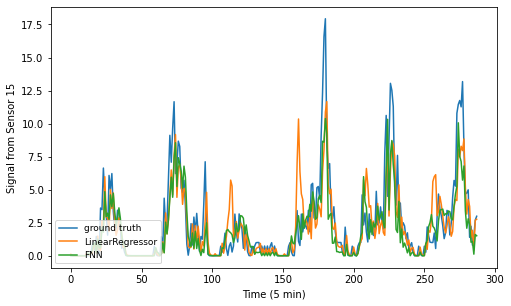

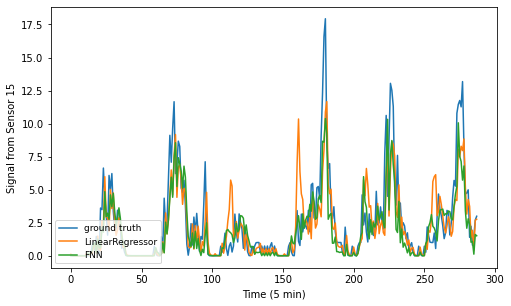

In [9]:
sensor_no = 15

for horizon in [0,2,11]:
    
    #plt.figure(figsize=(20,5))
    plt.figure(figsize=(8,4.8))
    plt.plot(run_info[MODEL_NAME]["ground_truth"][15,int(288*4.5):int(288*5.5),0],label='ground truth')
    plt.xlabel("Time (5 min)")
    plt.ylabel("Signal from Sensor {}".format(sensor_no))

    for MODEL_NAME in MODEL_NAMES:
        plt.plot(run_info[MODEL_NAME]['predictions'][15,int(288*4.5):int(288*5.5),0],label=MODEL_NAME)
        
        
    plt.legend(loc='lower left',prop={'size': 9})
    plt.savefig(os.path.join(PLOTS_DIRECTORY,'horizon_'+str(horizon+1)+'_'+DATASET_NAME+'.png'))